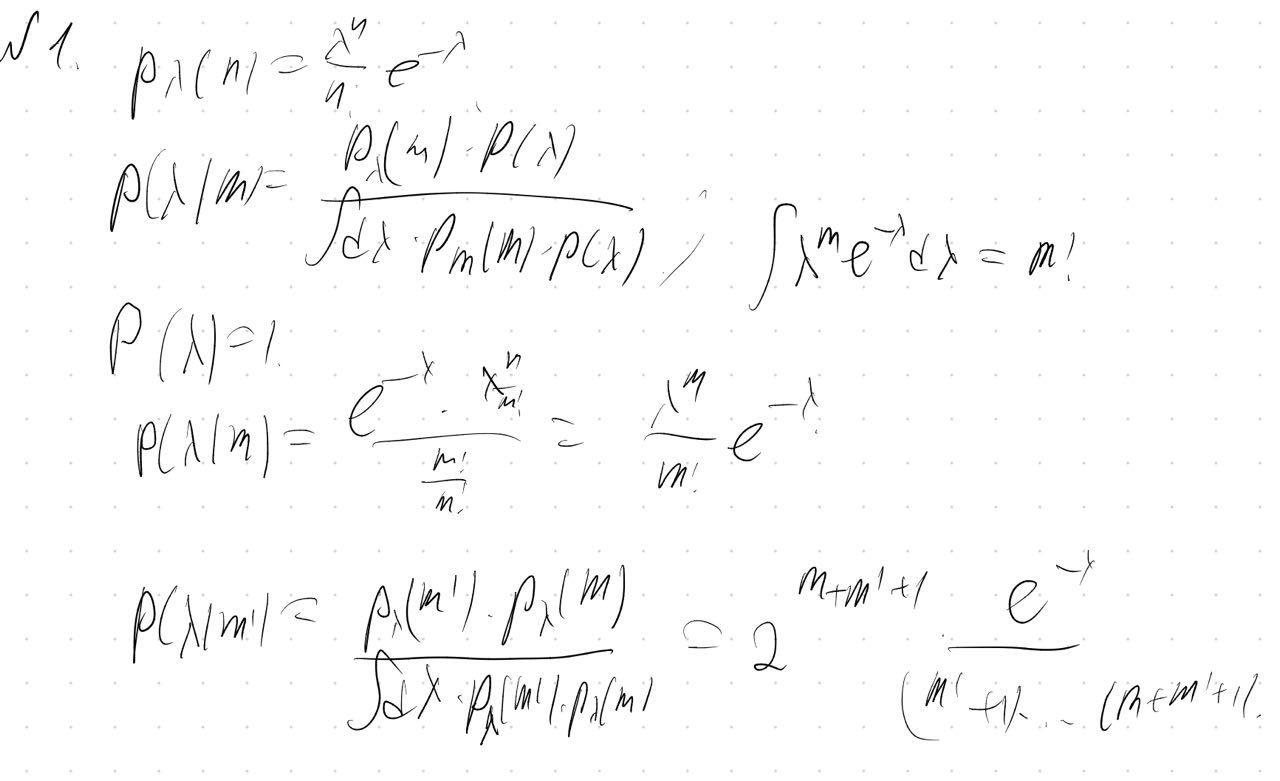

# Упражнение 2

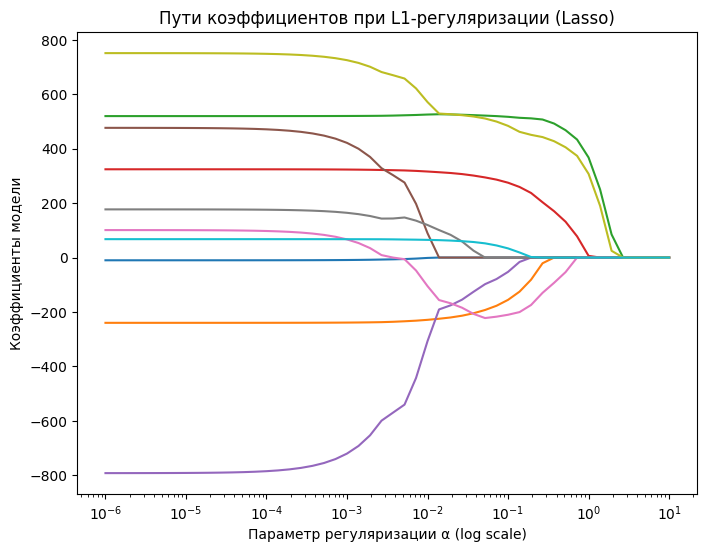

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Lasso

data, target = load_diabetes(return_X_y=True)

# диапазон параметра регуляризации
alphas = np.logspace(-6, 1, 50)

# cписок коэффициентов
coefs = []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(data, target)
    coefs.append(lasso.coef_)

plt.figure(figsize=(8, 6))
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('Параметр регуляризации α (log scale)')
plt.ylabel('Коэффициенты модели')
plt.title('Пути коэффициентов при L1-регуляризации (Lasso)')
plt.axis('tight')
plt.show()

K-Fold кросс-валидация (K=3):
LR	Lambda	MSE
------------------------------
0.001	0.001	0.090713
0.001	0.01	0.090781
0.001	0.1	0.106891
0.01	0.001	0.025117
0.01	0.01	0.027797
0.01	0.1	0.060917
0.1	0.001	0.019986
0.1	0.01	0.021136
0.1	0.1	0.062305

Лучшие параметры:
Learning Rate: 0.1
Lambda: 0.001
Лучший MSE: 0.019986

Обучение финальной модели...


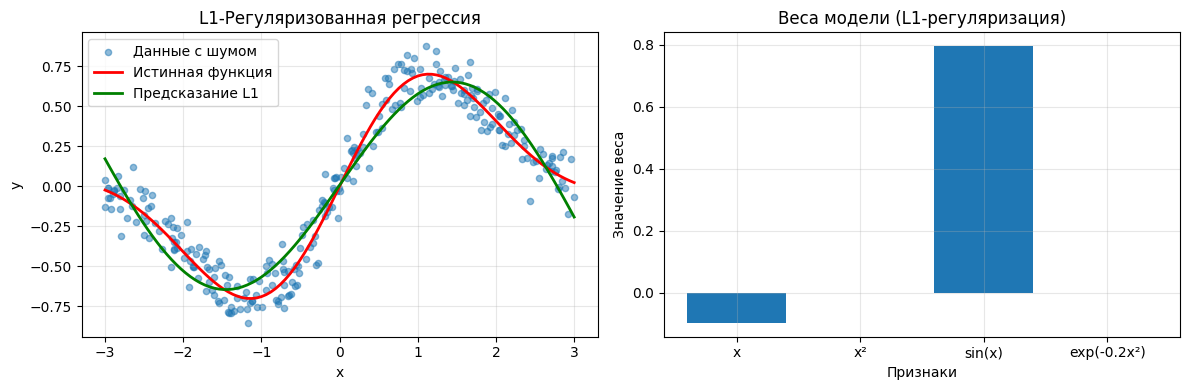

Веса модели: [-9.80705274e-02 -1.92421818e-03  7.96097697e-01 -9.32297692e-05]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Генерация данных с неполиномиальной функцией
def generate_data(n_samples=300):
    x_uniform = np.linspace(-3, 3, n_samples//2)
    
    x_random = np.random.uniform(-3, 3, n_samples//2)
    
    x = np.concatenate([x_uniform, x_random])
    
    # Неполиномиальная функция: sin(x) * exp(-x^2)
    y_clean = np.sin(x) * np.exp(-0.2 * x**2)
    
    noise = np.random.normal(0, 0.1, n_samples)
    y = y_clean + noise
    
    return x, y

# Ваша реализация градиентного спуска для L1-регрессии
def gradient_descent_l1(X, y, learning_rate, lambda_, n_iter=1000):
    n_samples, n_features = X.shape
    
    weights = np.random.randn(n_features) * 0.01
    bias = 0
    
    for i in range(n_iter):
        y_pred = np.dot(X, weights) + bias
        
        dw = (1/n_samples) * np.dot(X.T, (y_pred - y)) + lambda_ * np.sign(weights)
        db = (1/n_samples) * np.sum(y_pred - y)
        
        weights -= learning_rate * dw
        bias -= learning_rate * db
        
        if i > 10:
            current_loss = np.mean((y_pred - y)**2) + lambda_ * np.sum(np.abs(weights))
            if current_loss < 0.001:
                break
    
    return weights, bias

def compute_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def main():
    x, y = generate_data()
    X = x.reshape(-1, 1)
    
    X_poly = np.column_stack([x, x**2, np.sin(x), np.exp(-0.2*x**2)])
    
    # Параметры для подбора
    learning_rates = [0.001, 0.01, 0.1]
    lambdas = [0.001, 0.01, 0.1]
    
    # K-Fold кросс-валидация (K=3)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    best_score = float('inf')
    best_lr = None
    best_lambda = None
    
    print("K-Fold кросс-валидация (K=3):")
    print("LR\tLambda\tMSE")
    print("-" * 30)
    
    for lr in learning_rates:
        for lambda_ in lambdas:
            fold_scores = []
            
            for train_idx, val_idx in kf.split(X_poly):
                X_train, X_val = X_poly[train_idx], X_poly[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                
                weights, bias = gradient_descent_l1(X_train, y_train, lr, lambda_)
                
                y_pred = np.dot(X_val, weights) + bias
                
                mse = compute_mse(y_val, y_pred)
                fold_scores.append(mse)
            
            mean_score = np.mean(fold_scores)
            print(f"{lr}\t{lambda_}\t{mean_score:.6f}")
            
            if mean_score < best_score:
                best_score = mean_score
                best_lr = lr
                best_lambda = lambda_
    
    print(f"\nЛучшие параметры:")
    print(f"Learning Rate: {best_lr}")
    print(f"Lambda: {best_lambda}")
    print(f"Лучший MSE: {best_score:.6f}")
    
    print("\nОбучение финальной модели...")
    final_weights, final_bias = gradient_descent_l1(
        X_poly, y, best_lr, best_lambda, n_iter=2000
    )
    
    x_test = np.linspace(-3, 3, 100)
    X_test = np.column_stack([x_test, x_test**2, np.sin(x_test), np.exp(-0.2*x_test**2)])
    y_pred = np.dot(X_test, final_weights) + final_bias
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.scatter(x, y, alpha=0.5, s=20, label='Данные с шумом')
    
    y_true = np.sin(x_test) * np.exp(-0.2 * x_test**2)
    plt.plot(x_test, y_true, 'r-', linewidth=2, label='Истинная функция')
    plt.plot(x_test, y_pred, 'g-', linewidth=2, label='Предсказание L1')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('L1-Регуляризованная регрессия')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    features = ['x', 'x²', 'sin(x)', 'exp(-0.2x²)']
    plt.bar(features, final_weights)
    plt.xlabel('Признаки')
    plt.ylabel('Значение веса')
    plt.title('Веса модели (L1-регуляризация)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    print("Веса модели:", final_weights)

# Запуск
if __name__ == "__main__":
    main()

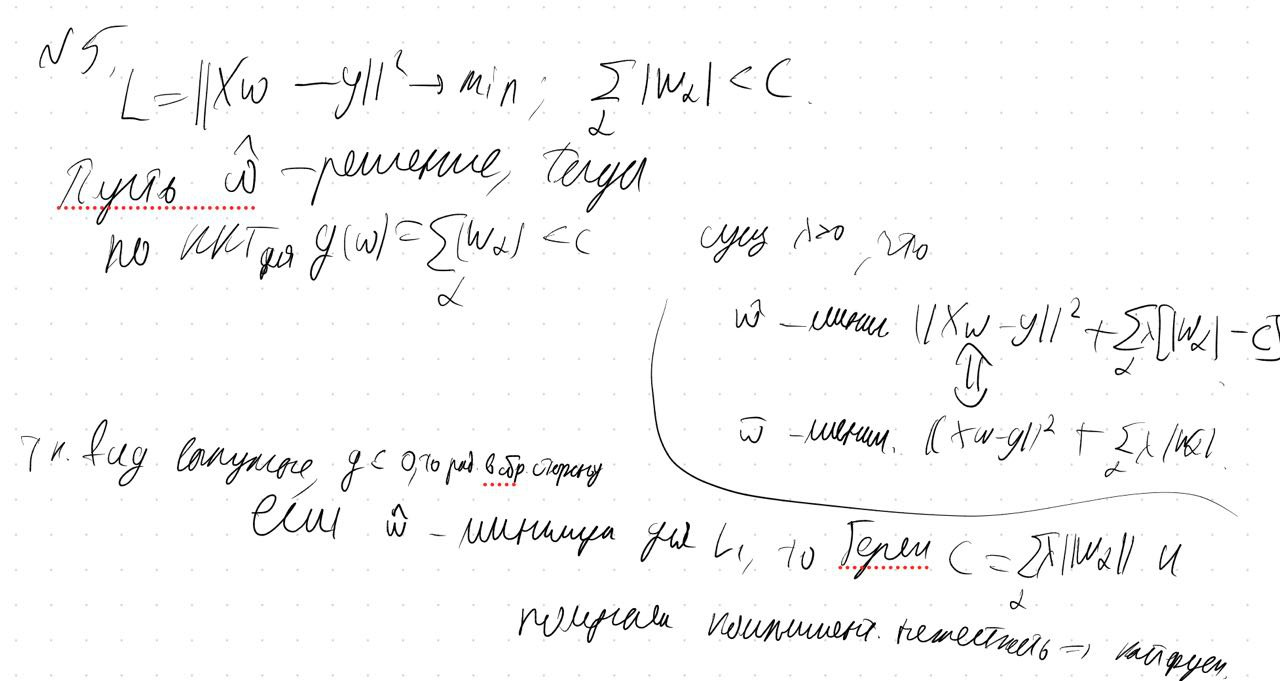